**Variational Auto-Encoders**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import *
from tqdm import tqdm

## Data Preparation

### Data Prep 1

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_digits.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(70000, 28, 28, 1)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

In [4]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

### Data Prep 2

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

print(mnist_digits.shape)

# Create an ImageDataGenerator for data augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
)

x_train = train_gen.flow(
    mnist_digits,
    shuffle=True,
    batch_size=128,
)

(70000, 28, 28, 1)


## Modeling VAES

In [6]:
LATENT_DIM = 2
BATCH_SIZE = 128

### Sampling

In [7]:
class Sampling(Layer):

    def call(self, inputs):
        mean, logvar = inputs
        return mean + tf.math.exp(0.5*logvar)*tf.random.normal(shape = tf.shape((BATCH_SIZE, LATENT_DIM)))

## Encoder

In [8]:
def Encoder(latent_dim = LATENT_DIM):

    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), strides = 2, padding="same")(inputs)
    x = Conv2D(64, (3, 3), strides  = 2, padding="same")(x)

    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    mean = Dense(LATENT_DIM,)(x)
    log_var = Dense(LATENT_DIM, )(x)

    z = Sampling()([mean, log_var])

    model = Model(inputs=inputs, outputs=[z,mean,log_var], name='VAE-Encoder')
    return model

Encoder_model = Encoder()
Encoder_model.summary()

Model: "VAE-Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

#### Testing Variational Encoder

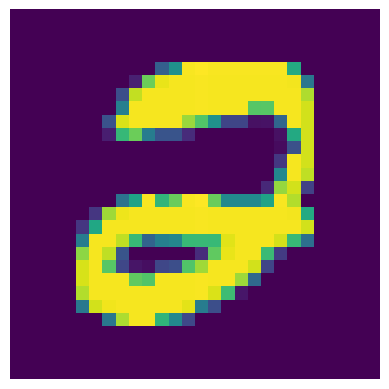

In [9]:
teste = x_train[0][0]
plt.imshow(teste)
plt.axis('off')
plt.show()

In [10]:
teste = tf.expand_dims(teste, axis = 0)
teste.shape

TensorShape([1, 28, 28, 1])

In [11]:
encoded_image = Encoder_model.predict(teste)
print('Z : ' + str(encoded_image[0]))
print('Mean : ' + str(encoded_image[1]))
print('Log_Var : ' + str(encoded_image[2]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
Z : [[ 1.1232095 -1.6582994]]
Mean : [[-0.19630553 -0.12396948]]
Log_Var : [[ 0.00316716 -0.11119043]]


## Decoder

In [12]:
def Decoder():

    latent_inputs = Input(shape=(LATENT_DIM,))
    x = Dense(7*7*64, activation='relu')(latent_inputs)
    x = Reshape((7,7,64))(x)

    x = Conv2DTranspose(64,(3,3), strides= 2, padding="same")(x)
    x = Conv2DTranspose(32,(3,3), strides= 2, padding="same")(x)
    x = Conv2DTranspose(1,(3,3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=latent_inputs, outputs=x, name='VAE-Decoder')
    return model

Decoder_model = Decoder()
Decoder_model.summary()

Model: "VAE-Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Testing Variational Decoder

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


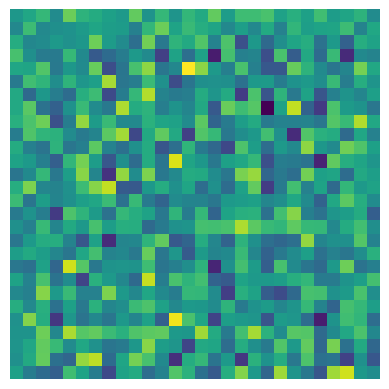

In [13]:
#Zero Shot

Dencoded_image = Decoder_model.predict(encoded_image[0])
plt.imshow(Dencoded_image[0])
plt.axis('off')
plt.show()

## VAE Full Model

In [14]:
def VAE():
    vae_inputs = Input(shape=(28, 28, 1))
    z, _, _ = Encoder_model(vae_inputs)
    outputs = Decoder_model(z)

    vae_model = Model(vae_inputs, outputs, name='VAE')
    return vae_model

VAE_model = VAE()
VAE_model.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ VAE-Encoder (Functional)             │ [(None, 2), (None, 2),      │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ VAE-Decoder (Functional)             │ (None, 28, 28, 1)           │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [15]:
def customized_loss(y_true, y_pred, mean, log_var):
    # Loss que tenta aproximar os valores de cada pixel do correto
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2)))

    # Loss que tenta aproximar os valores da média e do desvio padrão dos pixels
    # Para isso, utiliza o logaritmo natural para evitar problemas com números negativos
    regression_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.square(mean)-tf.exp(log_var)),axis = 1))

    return reconstruction_loss + regression_loss

In [ ]:
# class VAE_Model(Model):
#     def __init__(self, encoder, decoder):
#         super(VAE_Model, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.loss_tracker = tf.keras.metrics.Mean(name="loss")

#     @property
#     def metrics(self):
#         return [self.loss_tracker.result()]

#     def train_step(self, data):
#         with tf.GradientTape() as recorder:
#             z, mean, log_var = self.encoder(data)
#             y_pred = self.decoder(z)
#             loss = customized_loss(data, y_pred, mean, log_var)

#         gradients = recorder.gradient(loss, self.trainable_weights)
#         Adam(learning_rate = 0.0001).apply_gradients(zip(gradients, self.trainable_weights))

#         self.loss_tracker.update_state(loss)
#         return {'loss':self.loss_tracker.result()}


# vae_model = VAE_Model(Encoder_model, Decoder_model)
# vae_model.compile(optimizer=Adam(learning_rate = 0.0001))
# vae_model.fit(train_dataset, epochs=20)


In [16]:
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z, mean, log_var = Encoder_model(x_batch)
        y_pred = Decoder_model(z)
        loss = customized_loss(x_batch, y_pred, mean, log_var)

    gradients = recorder.gradient(loss, VAE_model.trainable_weights)
    Adam(learning_rate = 0.0001).apply_gradients(zip(gradients, VAE_model.trainable_weights))
    return loss

In [17]:
def train(data, epochs):
    for epoch in tqdm(range(epochs)):
        print('Epoch: ',epoch+1)

        for step, x_batch in enumerate(data):
            loss = training_block(x_batch)
        print('Training Loss: ',loss.numpy())
        if loss < 160:
            break

In [18]:
train(train_dataset, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  1


  5%|▌         | 1/20 [05:22<1:42:03, 322.28s/it]

Training Loss:  223.43465
Epoch:  2


 10%|█         | 2/20 [09:49<1:27:00, 290.01s/it]

Training Loss:  200.56818
Epoch:  3


 15%|█▌        | 3/20 [14:27<1:20:38, 284.61s/it]

Training Loss:  184.70677
Epoch:  4


 15%|█▌        | 3/20 [19:49<1:52:22, 396.60s/it]


KeyboardInterrupt: 

## Testing

In [ ]:
scale=1
n=16

In [ ]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [ ]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)

    input=tf.constant([[i,j]])
    out=VAE_model.layers[2].predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis('off')
    k+=1

In [ ]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train, -1).astype("float32") / 255

In [ ]:
z, _, _ = VAE_model.layers[1].predict(mnist_digits)

plt.figure(figsize=(12, 12))
plt.scatter(z[:, 0], z[:, 1], c=y_train, cmap="tab10")
plt.colorbar()